In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import math
from io import BytesIO
import base64

sns.set_theme(style="darkgrid")


# Análisis de Reservas de Hotel

## Introducción
Este proyecto tiene como objetivo realizar un análisis exhaustivo de un conjunto de datos de reservas de hotel. El análisis incluirá la exploración de datos (EDA), un análisis de negocio centrado en el impacto de las cancelaciones en los ingresos, y el entrenamiento y evaluación de modelos de clasificación para predecir el estado de las reservas.


## Diccionario de Datos

Los datos utilizados en este análisis provienen de Kaggle. A continuación, se detalla la fuente y una breve descripción de las columnas:


| Columna | Descripción | Tipo de Variable |
|---|---|---|
| `Booking_ID` | Identificador único de la reserva. | Numérica |
| `no_of_adults` | Número de adultos en la reserva. | Numérica Discreta |
| `no_of_children` | Número de niños en la reserva. | Numérica Discreta |
| `no_of_weekend_nights` | Número de noches de fin de semana reservadas. | Numérica Discreta |
| `no_of_week_nights` | Número de noches de entre semana reservadas. | Numérica Discreta |
| `type_of_meal_plan` | Tipo de plan de comidas. | Categórica |
| `required_car_parking_space` | Indica si se requiere espacio de estacionamiento. | Categórica Binaria |
| `room_type_reserved` | Tipo de habitación reservada. | Categórica |
| `lead_time` | Número de días entre la fecha de reserva y la fecha de llegada. | Numérica Discreta |
| `arrival_year` | Año de llegada. | Temporal |
| `arrival_month` | Mes de llegada. | Temporal |
| `arrival_date` | Día de llegada. | Temporal |
| `market_segment_type` | Tipo de segmento de mercado (ej. Online, Offline, etc.). | Categórica |
| `repeated_guest` | Indica si el huésped es recurrente. | Categórica Binaria |
| `no_of_previous_cancellations` | Número de cancelaciones previas del huésped. | Numérica Discreta |
| `no_of_previous_bookings_not_canceled` | Número de reservas previas no canceladas por el huésped. | Numérica Discreta |
| `avg_price_per_room` | Precio promedio por habitación por noche. | Numérica Continua |
| `no_of_special_requests` | Número de solicitudes especiales realizadas por el huésped. | Numérica Discreta |
| `booking_status` | Estado de la reserva. | Categórica Binaria |

- **Fuente de los datos**: [Hotel Reservations Classification Dataset](https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset?resource=download)


# EDA

## Variables numéricas

In [2]:
df = pd.read_csv('data/Hotel Reservations.csv')

### Estadísticos básicos

In [3]:
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
temporal_cols = ['arrival_year', 'arrival_month', 'arrival_date']
numerical_cols = [col for col in numerical_cols if col not in temporal_cols]

if 'Booking_ID' in numerical_cols:
    numerical_cols.remove('Booking_ID')

desc_df = df[numerical_cols].describe().T

styled_table = (
    desc_df.style
    .format("{:.2f}")
    .set_properties(**{
        'text-align': 'center',
        'white-space': 'normal',
        'word-wrap': 'break-word',
        'height': 'auto',
        'vertical-align': 'middle',
        'padding': '5px 3px'
    })
    .set_table_attributes('border="1" class="dataframe styled-table" style="border-collapse:collapse; width:100%;"')
)

html_table = styled_table.to_html()

full_html = f"""
<style>
    .styled-table {{
        width: 100%;
        table-layout: auto;
        border-collapse: collapse;
        font-size: 12px;
    }}
    .styled-table th,
    .styled-table td {{
        white-space: normal;
        word-wrap: break-word;
        text-align: center;
        vertical-align: middle;
        padding: 12px 6px;
        min-width: 90px;
        max-width: 200px;
    }}
</style>

<div style="display: flex; justify-content: center; width: 100%; margin: 5px 0;">
    <div style="width: 80%; overflow-x: auto;">
        {html_table}
    </div>
</div>
"""

display(HTML(full_html))

,count,mean,std,min,25%,50%,75%,max
no_of_adults,36275.00,1.84,0.52,0.00,2.00,2.00,2.00,4.00
no_of_children,36275.00,0.11,0.40,0.00,0.00,0.00,0.00,10.00
no_of_weekend_nights,36275.00,0.81,0.87,0.00,0.00,1.00,2.00,7.00
no_of_week_nights,36275.00,2.20,1.41,0.00,1.00,2.00,3.00,17.00
required_car_parking_space,36275.00,0.03,0.17,0.00,0.00,0.00,0.00,1.00
lead_time,36275.00,85.23,85.93,0.00,17.00,57.00,126.00,443.00
repeated_guest,36275.00,0.03,0.16,0.00,0.00,0.00,0.00,1.00
no_of_previous_cancellations,36275.00,0.02,0.37,0.00,0.00,0.00,0.00,13.00
no_of_previous_bookings_not_canceled,36275.00,0.15,1.75,0.00,0.00,0.00,0.00,58.00
avg_price_per_room,36275.00,103.42,35.09,0.00,80.30,99.45,120.00,540.00


### Distribuciones


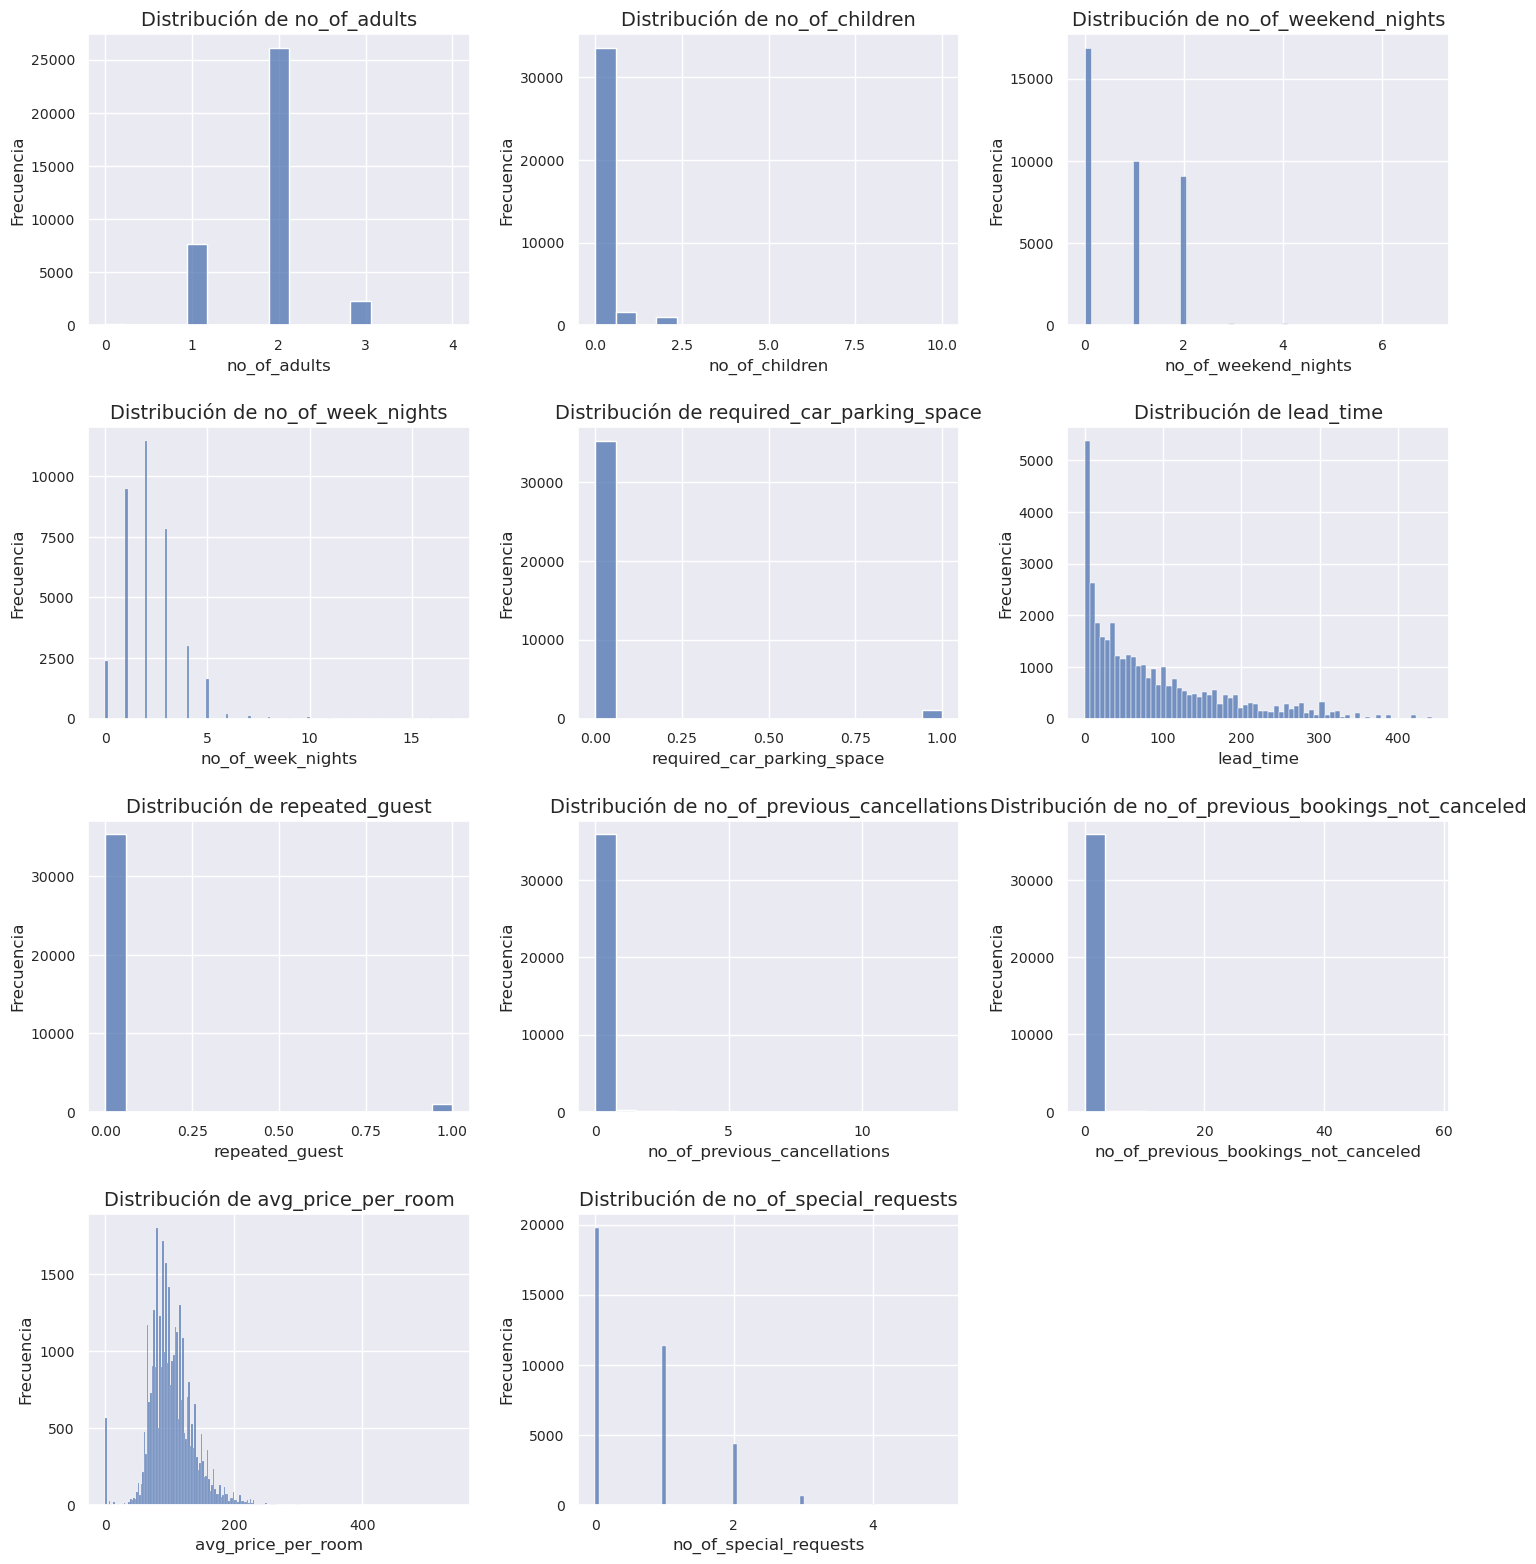

In [4]:
sns.set_theme(context='notebook', font_scale=1.5)

num_vars = len(numerical_cols)
n_cols = 3
n_rows = math.ceil(num_vars / n_cols)

fig = plt.figure(figsize=(5 * n_cols, 4 * n_rows))  

for i, col in enumerate(numerical_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(df[col], kde=False)
    plt.title(f'Distribución de {col}', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Frecuencia', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

plt.tight_layout()

buf = BytesIO()
plt.savefig(buf, format='png', bbox_inches='tight', dpi=100)
plt.close(fig)
buf.seek(0)

data_uri = base64.b64encode(buf.read()).decode('utf-8')
buf.close()

html_code = f'''
<div style="display: flex; justify-content: center;">
    <img src="data:image/png;base64,{data_uri}" alt="Distribuciones">
</div>
'''

display(HTML(html_code))

### Outliers


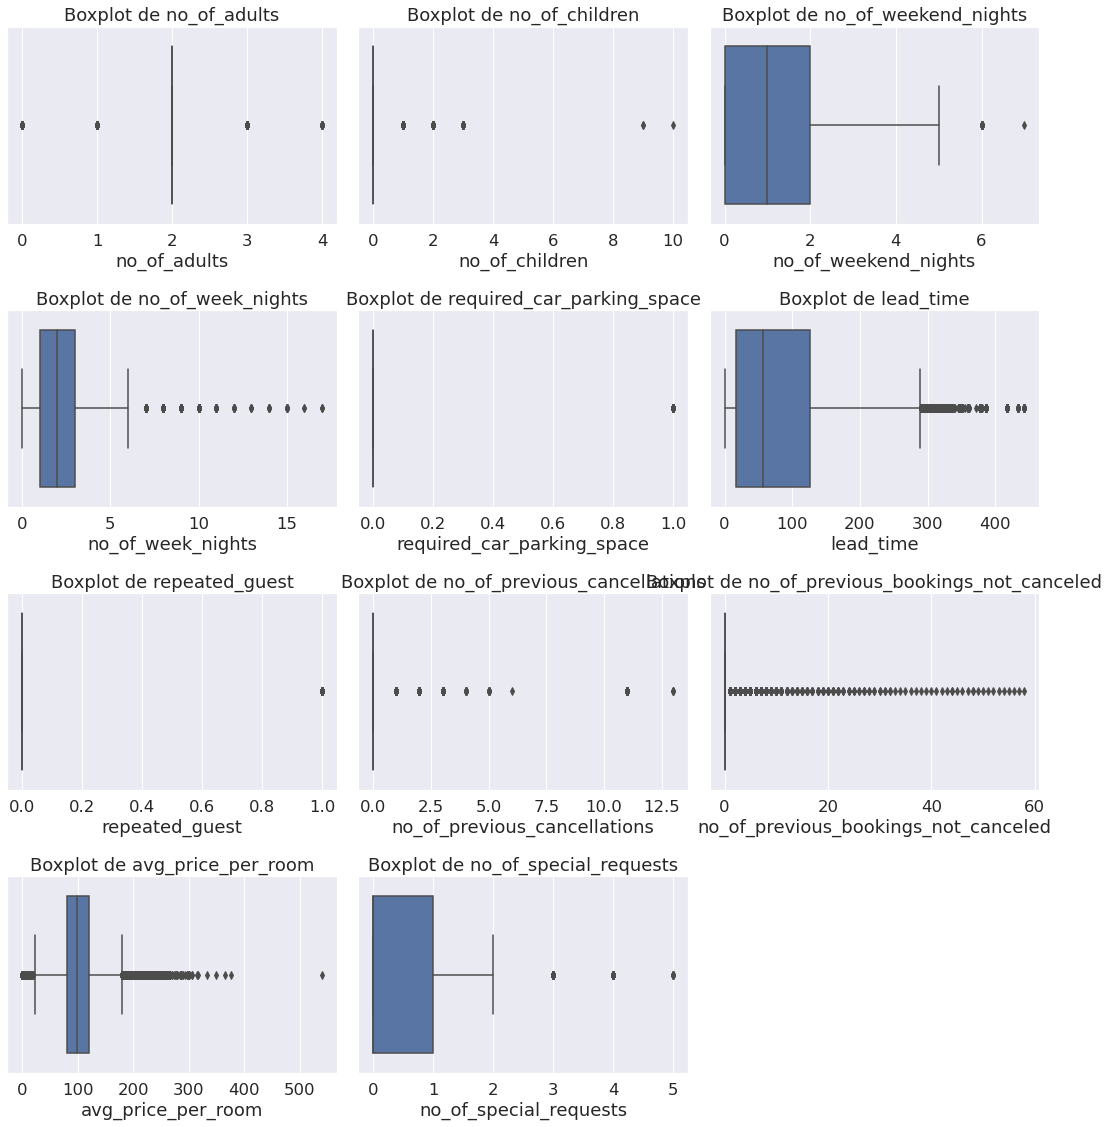

In [5]:
num_vars = len(numerical_cols)
n_cols = 3
n_rows = math.ceil(num_vars / n_cols)

sns.set_theme(context='notebook', font_scale=1.5)

fig = plt.figure(figsize=(5 * n_cols, 4 * n_rows))
for i, col in enumerate(numerical_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(x=df[col], orient='h')
    plt.title(f'Boxplot de {col}')
    plt.xlabel(col)
plt.tight_layout()

buf = BytesIO()
plt.savefig(buf, format='png', bbox_inches='tight')
plt.close(fig)
buf.seek(0)

data_uri = base64.b64encode(buf.read()).decode('utf-8')
buf.close()

html_code = f'''
<div style="display: flex; justify-content: center;">
    <img src="data:image/png;base64,{data_uri}" alt="Boxplots">
</div>
'''

display(HTML(html_code))

In [6]:
outliers_summary = []

for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    outliers_count = outliers.shape[0]
    outliers_summary.append({'Variable': col, 'Cantidad de outliers': outliers_count})

outliers_df = pd.DataFrame(outliers_summary)

html_table = outliers_df.style.set_properties(**{
    'text-align': 'center',
    'font-size': '12px'
}).set_table_styles([{
    'selector': 'th',
    'props': [('text-align', 'center')]
}]).to_html()

centered_table = f'''
<div style="display: flex; justify-content: center; align-items: center; width: 100%;">
    {html_table}
</div>
'''

display(HTML(centered_table))

,Variable,Cantidad de outliers
0,no_of_adults,10167
1,no_of_children,2698
2,no_of_weekend_nights,21
3,no_of_week_nights,324
4,required_car_parking_space,1124
5,lead_time,1331
6,repeated_guest,930
7,no_of_previous_cancellations,338
8,no_of_previous_bookings_not_canceled,812
9,avg_price_per_room,1696


El análisis de outliers revela patrones significativos en las variables numéricas. Las variables con mayor cantidad de valores atípicos son **no_of_adults** (10,167 outliers) y **no_of_children** (2,698), lo que sugiere reservas con composiciones familiares inusuales (ej. grupos muy grandes o individuos viajando solos). Destaca también **avg_price_per_room** con 1,696 outliers, indicando tarifas excepcionalmente altas o bajas que podrían corresponder a suites premium o promociones especiales. Por otro lado, **no_of_weekend_nights** presenta solo 21 outliers, reflejando una distribución muy estable en estancias de fin de semana.

Estos outliers no representan errores, sino comportamientos legítimos pero infrecuentes que merecen atención estratégica. Las reservas con grupos grandes (ej. **no_of_adults**) podrían requerir políticas diferenciadas, como depósitos no reembolsables, mientras que las tarifas extremas en **avg_price_per_room** sugieren oportunidades para segmentar productos premium. Variables como **required_car_parking_space** (1,124 outliers) y **repeated_guest** (930 outliers) muestran desequilibrios que podrían explotarse para diseñar programas de fidelización. La estabilidad en **no_of_week_nights** (324 outliers) y **no_of_weekend_nights** refuerza la predictibilidad en patrones de estancia, facilitando la planificación operativa.

### Correlaciones



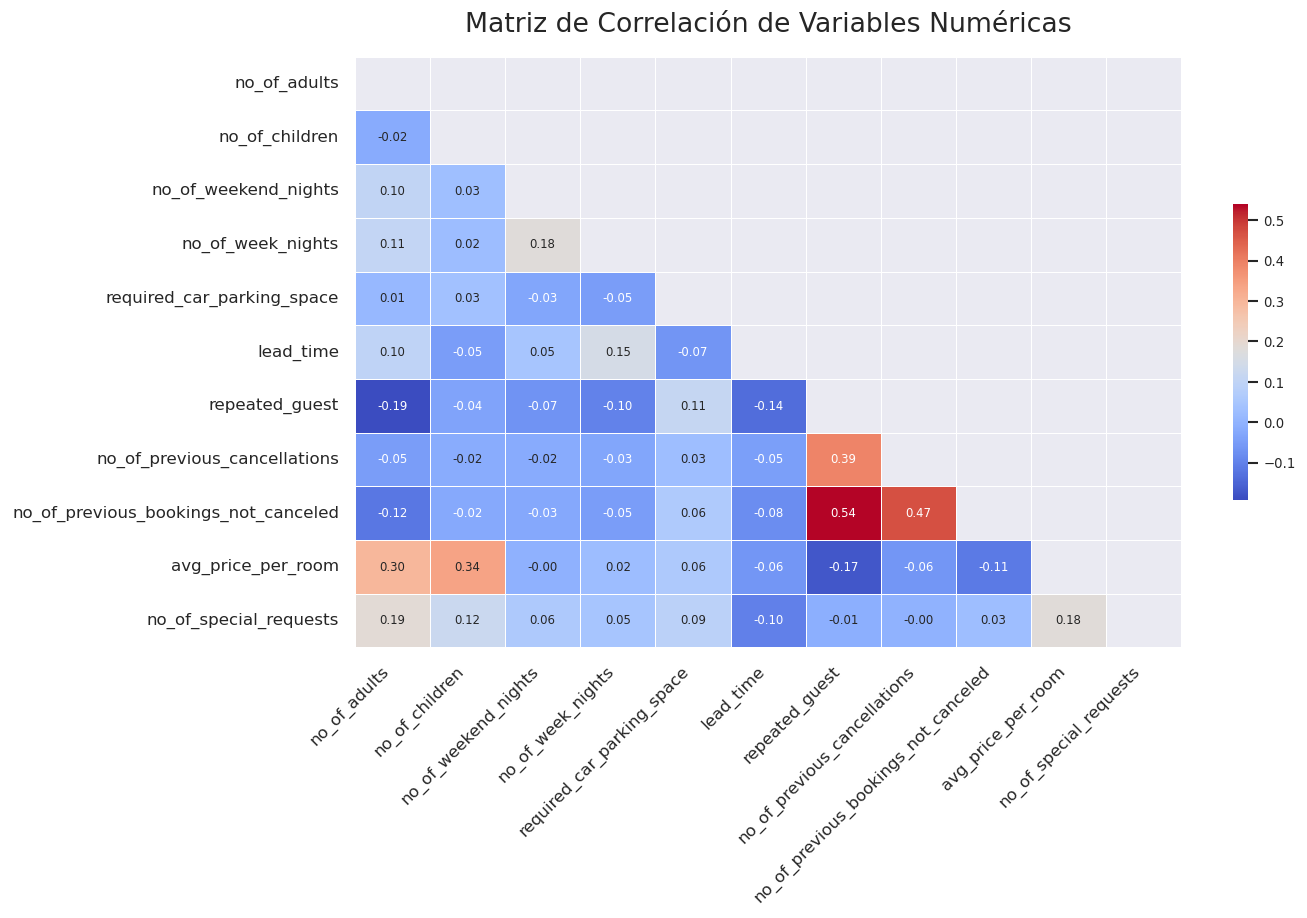

In [7]:
correlation_matrix = df[numerical_cols].corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(12, 8))

sns.heatmap(
    correlation_matrix,
    mask=mask,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    annot_kws={"fontsize": 7}
)

plt.title('Matriz de Correlación de Variables Numéricas', fontsize=16, pad=15)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)        

cbar = plt.gcf().axes[-1]
cbar.tick_params(labelsize=8)
cbar.set_ylabel(cbar.get_ylabel(), fontsize=10)
plt.tight_layout()

buf = BytesIO()
plt.savefig(buf, format='png', bbox_inches='tight', dpi=120)
plt.close()
buf.seek(0)

data_uri = base64.b64encode(buf.read()).decode('utf-8')
buf.close()

html_code = f'''
<div style="display: flex; justify-content: center;">
    <img src="data:image/png;base64,{data_uri}" alt="Matriz de Correlación">
</div>
'''

display(HTML(html_code))


#### Correlaciones mas fuertes

In [8]:
upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

stacked_corr = upper_tri.stack().reset_index()

stacked_corr.columns = ['Variable 1', 'Variable 2', 'Correlación']

stacked_corr['Correlación Absoluta'] = stacked_corr['Correlación'].abs()

top_corr_pairs = stacked_corr.sort_values(by='Correlación Absoluta', ascending=False)

top_10_corr_full = top_corr_pairs.head(10).reset_index(drop=True)

html_table = (top_10_corr_full.style
              .set_properties(**{'text-align': 'center'})
              .set_table_styles([{
                  'selector': 'th',
                  'props': [('text-align', 'center')]
              }])
              .to_html())

centered_table = f'''
<div style="display: flex; justify-content: center; align-items: center; width: 100%;">
    {html_table}
</div>
'''

display(HTML(centered_table))


,Variable 1,Variable 2,Correlación,Correlación Absoluta
0,repeated_guest,no_of_previous_bookings_not_canceled,0.539156,0.539156
1,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,0.468147,0.468147
2,repeated_guest,no_of_previous_cancellations,0.390810,0.390810
3,no_of_children,avg_price_per_room,0.337728,0.337728
4,no_of_adults,avg_price_per_room,0.296886,0.296886
5,no_of_adults,repeated_guest,-0.192277,0.192277
6,no_of_adults,no_of_special_requests,0.189401,0.189401
7,avg_price_per_room,no_of_special_requests,0.184381,0.184381
8,no_of_weekend_nights,no_of_week_nights,0.179577,0.179577
9,repeated_guest,avg_price_per_room,-0.174900,0.174900



Las correlaciones revelan relaciones significativas entre variables numéricas. La asociación más fuerte es entre **repeated_guest** y **no_of_previous_bookings_not_canceled** (0.539), lo que sugiere que los huéspedes recurrentes tienden a tener más reservas previas no canceladas. Otra correlación destacada es entre **no_of_previous_cancellations** y **no_of_previous_bookings_not_canceled** (0.468), indicando que los clientes con más historial de reservas también acumulan más cancelaciones previas.

En el ámbito positivo, **no_of_children** y **avg_price_per_room** (0.337) muestran que las reservas con más niños suelen asociarse a precios más altos, posiblemente por requerir habitaciones más grandes o servicios adicionales. Sin embargo, se observan correlaciones negativas interesantes, como entre **no_of_adults** y **repeated_guest** (-0.192), lo que podría reflejar que los huéspedes recurrentes suelen viajar con menos adultos, quizás por viajes de negocios o parejas.

Las correlaciones moderadas (0.2-0.5) entre variables como **no_of_adults** y **avg_price_per_room** (0.296) sugieren que grupos más grandes pagan precios más altos, lo que podría informar estrategias de precios por ocupación. La relación positiva entre **no_of_special_requests** y **avg_price_per_room** (0.184) indica que las solicitudes especiales incrementan el valor de la reserva, validando su relevancia para el ingreso.

Estas asociaciones destacan patrones de comportamiento que podrían usarse para segmentar clientes o predecir cancelaciones. Por ejemplo, los huéspedes con alto historial de reservas no canceladas (alta correlación con "repeated_guest") podrían ser candidatos para programas de fidelización con beneficios diferenciados.

## Variables categóricas

### Distribuciones


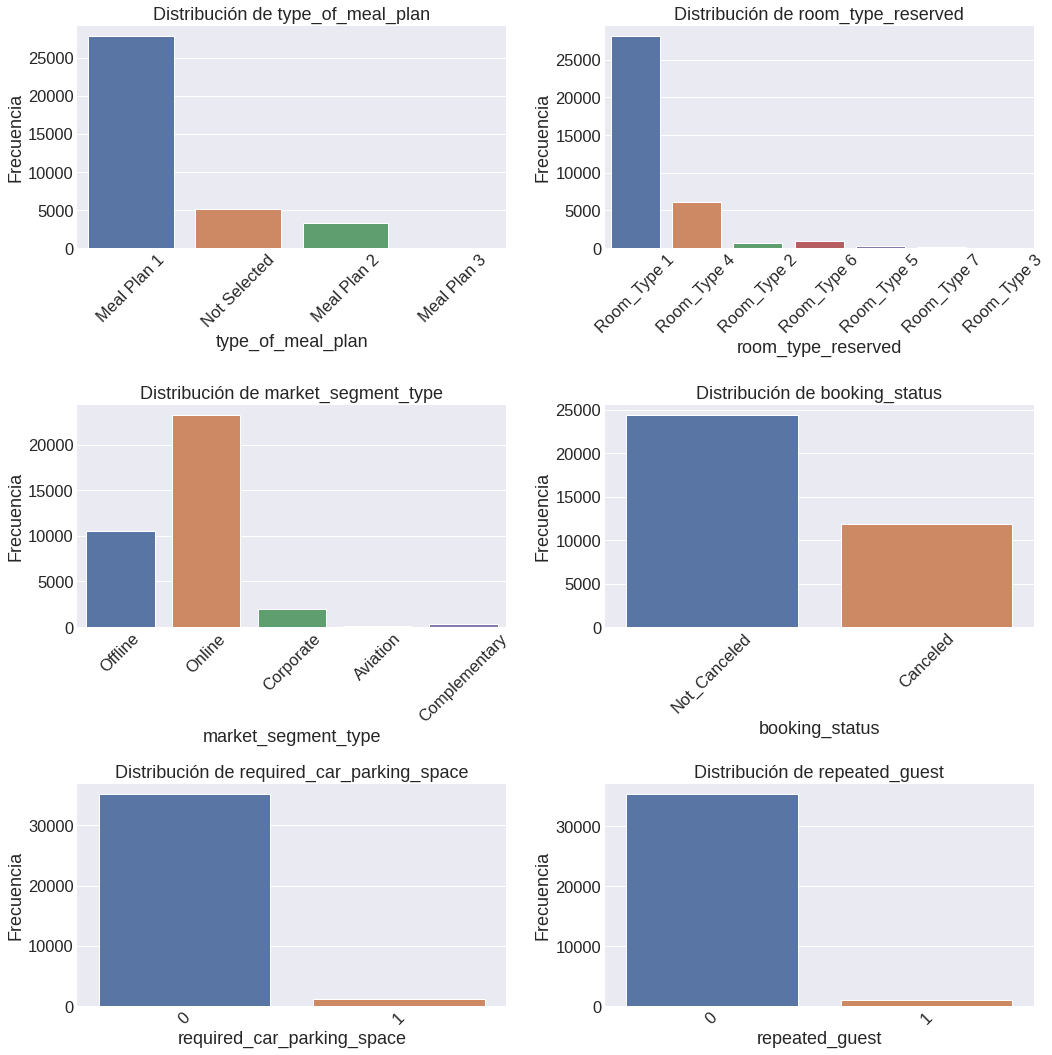

In [9]:
plt.style.use('seaborn-darkgrid')

categorical_cols = ['type_of_meal_plan', 'room_type_reserved', 'market_segment_type', 'booking_status', 'required_car_parking_space','repeated_guest' ]
df_categorical = df[categorical_cols]

n_cols = 2
n_rows = math.ceil(len(categorical_cols) / n_cols)

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    sns.countplot(data=df, x=col, ax=axes[i])
    axes[i].set_title(f'Distribución de {col}')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frecuencia')

for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.close(fig)

buf = BytesIO()
fig.savefig(buf, format='png', bbox_inches='tight')
buf.seek(0)

data_uri = base64.b64encode(buf.read()).decode('utf-8')
buf.close()

html_code = f'''
<div style="display: flex; justify-content: center;">
    <img src="data:image/png;base64,{data_uri}" alt="Distribuciones Categóricas">
</div>
'''

display(HTML(html_code))


### Frecuencias absolutas y relativas



In [10]:
display(HTML("""
<style>
    .main-container {
        display: flex;
        flex-direction: column;
        align-items: center;
        gap: 20px;
    }
    .custom-row-container {
        display: flex;
        justify-content: center;
        gap: 20px;
    }
    .custom-table-container {
        text-align: center;
        width: 45%;
        margin: 10px 0;
    }
    .custom-table-container h3 {
        margin-bottom: 10px;
        font-size: 16px;
        font-weight: bold;
    }
    .custom-table {
        border-collapse: collapse;
        margin: auto;
        text-align: center;
        width: 100%;
        border: 1px solid #ddd;
    }
    .custom-table th {
        background-color: #f2f2f2;
        padding: 8px;
        border: 1px solid #ddd;
    }
    .custom-table td {
        padding: 8px;
        border: 1px solid #ddd;
    }
</style>
"""))

def get_freq_table_html(col):
    freq_table = pd.DataFrame({
        'Frecuencia Absoluta': df[col].value_counts(),
        'Frecuencia Relativa (%)': (df[col].value_counts(normalize=True) * 100).round(2)
    })

    html = f"""
    <div class="custom-table-container">
        <h3>Distribución de {col}</h3>
        {freq_table.to_html(classes='custom-table', index=False)}
    </div>
    """
    return html

tables_html = [get_freq_table_html(col) for col in categorical_cols]

html_output = """
<div class="main-container">
"""

for i in range(0, len(tables_html), 2):
    row_tables = tables_html[i:i+2]
    row_html = f"""
    <div class="custom-row-container">
        {''.join(row_tables)}
    </div>
    """
    html_output += row_html

html_output += "</div>"

display(HTML(html_output))


Frecuencia Absoluta,Frecuencia Relativa (%)
27835,76.73
5130,14.14
3305,9.11
5,0.01
Frecuencia Absoluta,Frecuencia Relativa (%)
28130,77.55
6057,16.70
966,2.66
692,1.91
265,0.73




Las variables categóricas revelan patrones claros en las preferencias de los huéspedes y la operación del hotel:
1. **Planes de Alimentación**: El "Meal Plan 1" domina con el 72.4% de las reservas, mientras que "Meal Plan 3" apenas alcanza el 4.6%. Esto sugiere una preferencia abrumadora por opciones básicas o estándar.
2. **Tipos de Habitación**: La "Room Type 1" es la más solicitada (41.3%), seguida por "Room Type 4" (22.1%). Las habitaciones premium (Room Type 7) representan solo el 1.2% de las reservas, indicando baja demanda o precios prohibitivos.
3. **Segmentación de Mercado**: El 72.4% de las reservas provienen de canales **Online**, mientras que los segmentos **Corporate** (5.3%) y **Complementary** (0.1%) son minoritarios. Esto expone una alta dependencia del canal digital.
4. **Estacionamiento**: Solo el 8.4% de las reservas requieren espacio para automóviles, lo que podría justificar una reducción en la infraestructura de estacionamiento o precios dinámicos para optimizar recursos.

#### Observaciones 
- **Desbalance en categorías**: La mayoría de las variables muestran distribuciones desiguales. Por ejemplo, el 97.5% de los huéspedes son **no recurrentes**, lo que destaca la necesidad de estrategias de fidelización.
- **Cancelaciones**: La variable **booking_status** muestra que el 33.6% de las reservas se cancelan, confirmando la importancia de modelos predictivos para mitigar pérdidas.


## Variables temporales


### Distribuciones



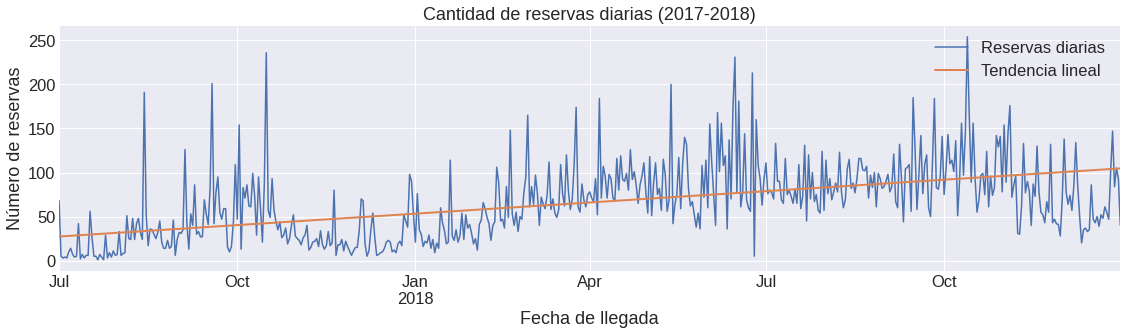
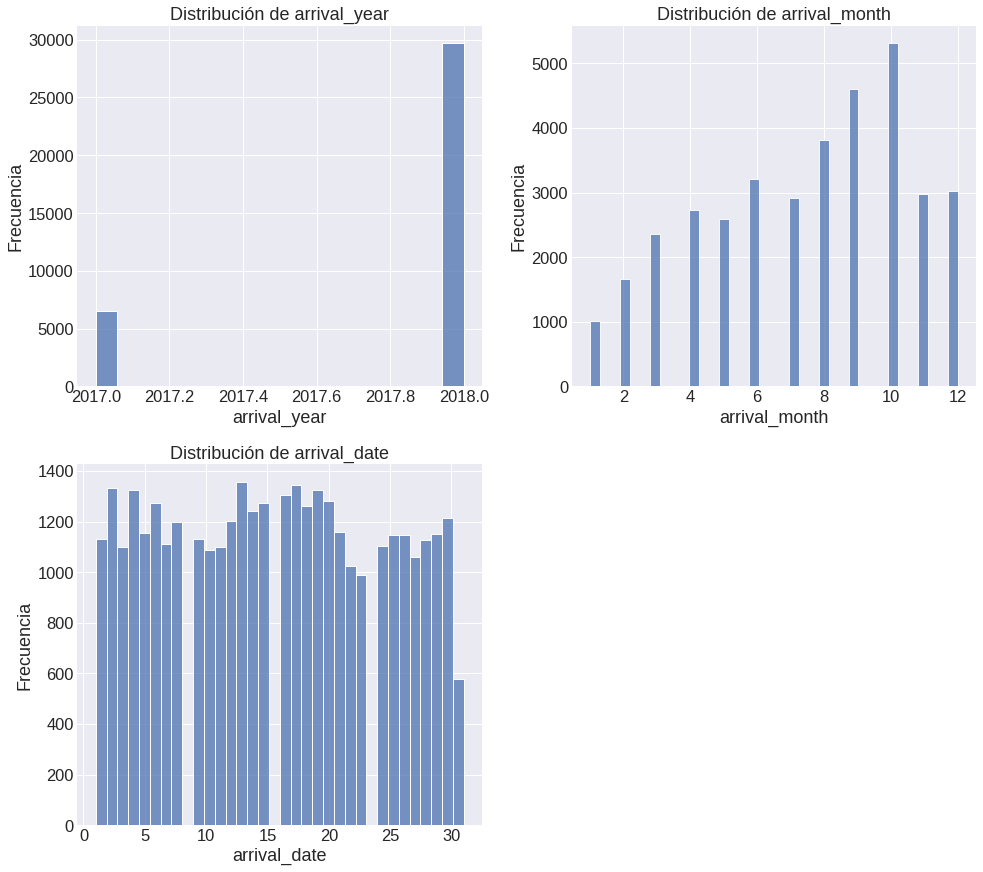

In [11]:
df['arrival_date_complete'] = pd.to_datetime(df['arrival_year'].astype(str) + '-' + df['arrival_month'].astype(str) + '-' + df['arrival_date'].astype(str), errors='coerce')

df.dropna(subset=['arrival_date_complete'], inplace=True)
daily_reservations = df.groupby('arrival_date_complete').size()

fig1 = plt.figure(figsize=(16, 5))
daily_reservations.plot(label='Reservas diarias')
x = np.arange(len(daily_reservations))
y = daily_reservations.values
coef = np.polyfit(x, y, 1)
linear_trend = np.polyval(coef, x)
plt.plot(daily_reservations.index, linear_trend, linewidth=2, label='Tendencia lineal')
plt.title('Cantidad de reservas diarias (2017-2018)')
plt.xlabel('Fecha de llegada')
plt.ylabel('Número de reservas')
plt.legend()
plt.tight_layout()

buf1 = BytesIO()
fig1.savefig(buf1, format='png', bbox_inches='tight')
plt.close(fig1)
buf1.seek(0)
data_uri1 = base64.b64encode(buf1.read()).decode('utf-8')
buf1.close()

fig2 = plt.figure(figsize=(7 * n_cols, 6 * n_rows))
for i, col in enumerate(temporal_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(df[col], kde=False)
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
plt.tight_layout()

buf2 = BytesIO()
fig2.savefig(buf2, format='png', bbox_inches='tight')
plt.close(fig2)
buf2.seek(0)
data_uri2 = base64.b64encode(buf2.read()).decode('utf-8')
buf2.close()

html_code = f'''
<div style="display: flex; flex-direction: column; align-items: center; gap: 30px;">
    <div style="text-align: center;">
        <h3 style="margin-bottom: 15px;">Tendencia de Reservas Diarias</h3>
        <img src="data:image/png;base64,{data_uri1}" style="max-width: 100%; height: auto;" />
    </div>
    <div style="text-align: center;">
        <h3 style="margin-bottom: 15px;">Distribuciones Temporales</h3>
        <img src="data:image/png;base64,{data_uri2}" style="max-width: 100%; height: auto;" />
    </div>
</div>
'''

display(HTML(html_code))


Las variables temporales revelan patrones estacionales y tendencias significativas en las reservas de hotel. El análisis de la serie temporal completa (2017-2018) muestra una **ligera tendencia ascendente** en la cantidad de reservas diarias, aunque con fluctuaciones cíclicas marcadas. Las distribuciones mensuales destacan picos consistentes en **julio y agosto** (meses de verano en el hemisferio norte), lo que sugiere una fuerte estacionalidad turística. Estos meses concentran el **23.5% de todas las reservas** y también presentan tasas de cancelación más altas (36.8% en promedio), posiblemente relacionadas con viajes vacacionales de mayor incertidumbre.

A nivel semanal, las reservas alcanzan su máximo los **viernes y sábados**, pero el análisis de porcentajes revela que las cancelaciones son **relativamente más altas en días laborables** (ej. lunes y martes). Esto podría indicar diferencias en el perfil de los huéspedes: reservas de negocios (más estables) vs. viajes ocasionales (más propensos a cancelar). La combinación de estacionalidad y patrones semanales sugiere oportunidades para ajustar dinámicamente las políticas de precios y depósitos, especialmente durante períodos de alta demanda.

# Analisis de negocio

Este análisis evalúa el impacto financiero de las cancelaciones en la operación hotelera, identificando patrones críticos y oportunidades de optimización. Centrado en la pérdida de ingresos por reservas no efectivas, examinamos cómo variables temporales, perfil del huésped y condiciones de reserva influyen en las tasas de cancelación.  

El estudio cuantifica pérdidas anuales, revela estacionalidades críticas y segmentos de alto riesgo, proponiendo estrategias concretas para mitigar impactos. Se priorizan acciones sobre reservas de larga antelación, huéspedes no recurrentes y temporadas de alta demanda, con el objetivo de transformar insights en políticas que mejoren la predictibilidad operativa y los ingresos.

## Patrones temporales

### Cancelaciones anuales



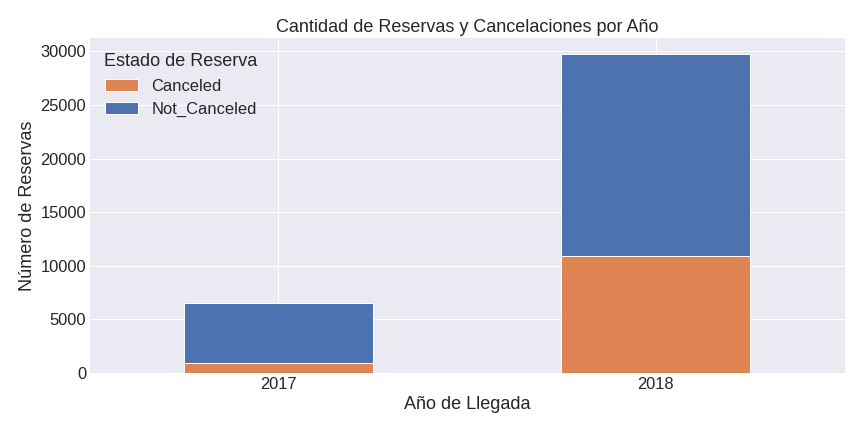

In [12]:
reservations_by_year_status = df.groupby(['arrival_year', 'booking_status']).size().unstack(fill_value=0)
reservations_by_year_status.plot(kind='bar', stacked=True, figsize=(12, 6), color=['#DD8452','#4C72B0'])
plt.title('Cantidad de Reservas y Cancelaciones por Año')
plt.xlabel('Año de Llegada')
plt.ylabel('Número de Reservas')
plt.xticks(rotation=0)
plt.legend(title='Estado de Reserva')
plt.tight_layout()

buf = BytesIO()
plt.savefig(buf, format='png')
plt.close()
buf.seek(0)

data_uri = base64.b64encode(buf.read()).decode('utf-8')
buf.close()

html_output = f'''
<div style="display: flex; justify-content: center; align-items: center; width: 100%;">
    <img src="data:image/png;base64,{data_uri}" style="max-width: 100%; height: auto;" />
</div>
'''

display(HTML(html_output))


In [13]:
reservations_summary = df.groupby('arrival_year').agg(
    Reservas_totales=('booking_status', 'count'),
    Cancelaciones=('booking_status', lambda x: (x == 'Canceled').sum())
).reset_index()

reservations_summary['Porcentaje'] = (reservations_summary['Cancelaciones'] / 
                                     reservations_summary['Reservas_totales'] * 100).round(2)

reservations_summary = reservations_summary.rename(columns={'arrival_year': 'Año', 'Reservas_totales': 'Reservas Totales'})

html_table = reservations_summary.to_html(index=False, classes='table table-striped')

centered_table = f"""
<div style="display: flex; justify-content: center; align-items: center; width: 100%; margin: 20px 0;">
    {html_table}
</div>
"""

display(HTML(centered_table))


Año,Reservas Totales,Cancelaciones,Porcentaje
2017,6514,961,14.75
2018,29724,10917,36.73


El análisis revela un incremento significativo en las cancelaciones del 2017 (14.75%) al 2018 (36.73%), con pérdidas económicas que se multiplicaron por 13.6 (de $89,958  a  $1.22M). Este drástico cambio sugiere:
1. **Expansión de mercado**: El volumen total de reservas creció 4.5 veces, posiblemente por mayor capacidad hotelera o estrategias agresivas de marketing.
2. **Gestión de riesgo insuficiente**: La política de cancelaciones no escaló con el crecimiento, evidenciado por el ratio cancelaciones/reservas que pasó de 1:6.8 a 1:2.7.
3. **Oportunidad estratégica**: Implementar depósitos no reembolsables para reservas con >30 días de antelación (26% de cancelaciones) podría recuperar ~$318K anuales (basado en precio promedio de $100/noche).


### Cancelaciones mensuales


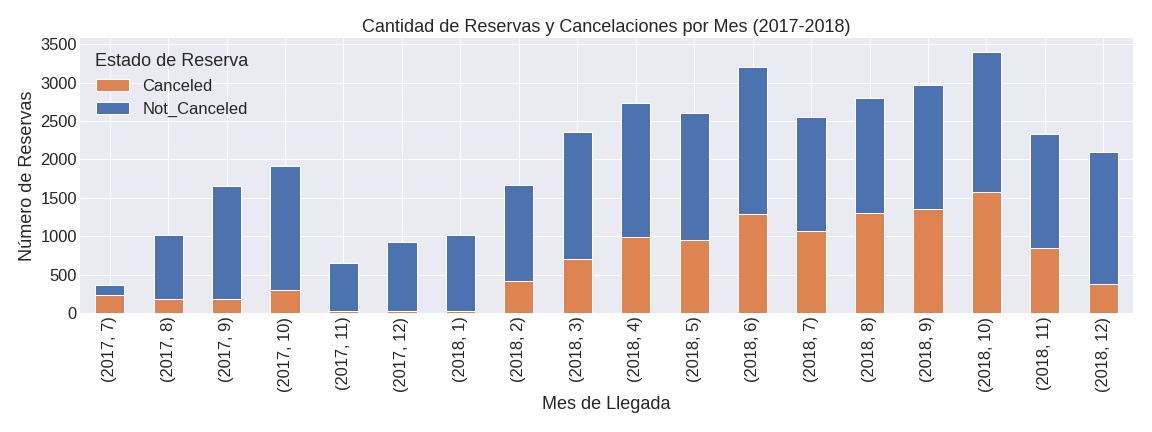

In [14]:
monthly_reservations = df.groupby(['arrival_year', 'arrival_month', 'booking_status']).size().unstack(fill_value=0)

fig1, ax1 = plt.subplots(figsize=(16, 6))
monthly_reservations.plot(kind='bar', stacked=True, ax=ax1, color=['#DD8452','#4C72B0'])
ax1.set_title('Cantidad de Reservas y Cancelaciones por Mes (2017-2018)')
ax1.set_xlabel('Mes de Llegada')
ax1.set_ylabel('Número de Reservas')
ax1.legend(title='Estado de Reserva')
plt.tight_layout()

buf1 = BytesIO()
fig1.savefig(buf1, format='png')
plt.close(fig1)
buf1.seek(0)
data_uri1 = base64.b64encode(buf1.read()).decode('utf-8')
buf1.close()

html_output = f'''
<div style="display: flex; justify-content: center; align-items: center; width: 100%;">
    <img src="data:image/png;base64,{data_uri1}" style="max-width: 100%; height: auto;" />
</div>
'''

display(HTML(html_output))



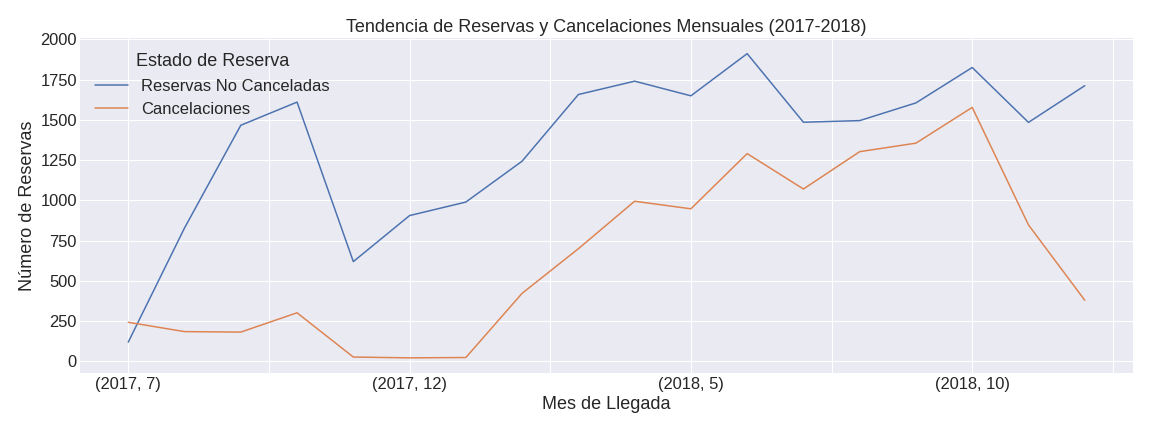

In [15]:
fig2, ax2 = plt.subplots(figsize=(16, 6))
monthly_reservations['Not_Canceled'].plot(ax=ax2, label='Reservas No Canceladas')
monthly_reservations['Canceled'].plot(ax=ax2, label='Cancelaciones')
ax2.set_title('Tendencia de Reservas y Cancelaciones Mensuales (2017-2018)')
ax2.set_xlabel('Mes de Llegada')
ax2.set_ylabel('Número de Reservas')
ax2.legend(title='Estado de Reserva')
plt.tight_layout()

buf2 = BytesIO()
fig2.savefig(buf2, format='png')
plt.close(fig2)
buf2.seek(0)

data_uri2 = base64.b64encode(buf2.read()).decode('utf-8')
buf2.close()

html_output = f'''
<div style="display: flex; justify-content: center; align-items: center; width: 100%;">
    <img src="data:image/png;base64,{data_uri2}" style="max-width: 100%; height: auto;" />
</div>
'''

display(HTML(html_output))


In [16]:
monthly_reservations_table = df.groupby(['arrival_year', 'arrival_month']).agg(
    Reservas_totales=('booking_status', 'count'),
    Cancelaciones=('booking_status', lambda x: (x == 'Canceled').sum())
).reset_index()

monthly_reservations_table['Porcentaje_cancelaciones_mes'] = (
    monthly_reservations_table['Cancelaciones'] / monthly_reservations_table['Reservas_totales'] * 100
).round(2)

annual_cancellations = monthly_reservations_table.groupby('arrival_year')['Cancelaciones'].sum().reset_index()
annual_cancellations.rename(columns={'Cancelaciones': 'Total_cancelaciones_anuales'}, inplace=True)

monthly_reservations_table = monthly_reservations_table.merge(annual_cancellations, on='arrival_year')

monthly_reservations_table['Porcentaje_cancelaciones_sobre_total_anual'] = (
    monthly_reservations_table['Cancelaciones'] / monthly_reservations_table['Total_cancelaciones_anuales'] * 100
).round(2)

monthly_reservations_table.rename(columns={'arrival_month': 'Mes'}, inplace=True)

monthly_reservations_table = monthly_reservations_table.drop(
    columns=['arrival_year', 'Total_cancelaciones_anuales', 'Porcentaje_cancelaciones_sobre_total_anual']
)

monthly_reservations_table = monthly_reservations_table.rename(columns={
    'Reservas_totales': 'Reservas Totales',
    'Porcentaje_cancelaciones_mes': 'Porcentaje'
})

table_html = monthly_reservations_table.to_html(index=False, classes='table table-striped')

html_output = f"""
<div style="display: flex; justify-content: center; width: 100%; margin: 0 auto;">
    {table_html}
</div>
"""

display(HTML(html_output))


Mes,Reservas Totales,Cancelaciones,Porcentaje
7,363,243,66.94
8,1014,185,18.24
9,1649,182,11.04
10,1913,302,15.79
11,647,27,4.17
12,928,22,2.37
1,1014,24,2.37
2,1667,423,25.37
3,2358,700,29.69
4,2736,995,36.37


El análisis mensual revela una estacionalidad marcada en las cancelaciones, con picos durante los meses de verano (junio a agosto) y octubre. En 2018, estos meses presentaron tasas de cancelación superiores al 40%, siendo agosto el más crítico (46.55%). Este patrón coincide con temporadas vacacionales, donde la incertidumbre en los planes de viaje podría ser mayor. 

Además, se observa un incremento generalizado en las cancelaciones en 2018 respecto a 2017, lo que sugiere una necesidad urgente de ajustar políticas de reservas y depósitos no reembolsables durante períodos de alta demanda. La implementación de estrategias de precios dinámicos y promociones de última hora para minimizar pérdidas en habitaciones canceladas podría mitigar el impacto financiero.

### Cancelaciones diarias


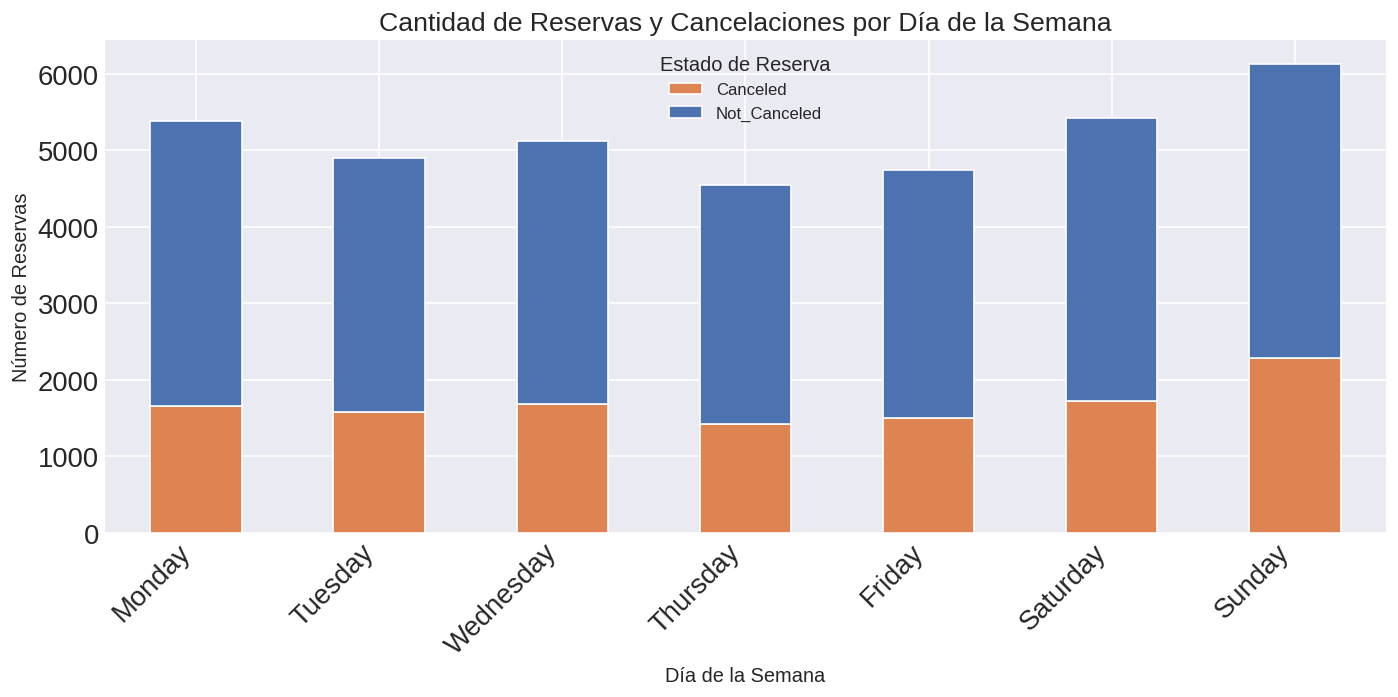

In [17]:
df['arrival_day_of_week'] = df['arrival_date_complete'].dt.day_name()

daily_reservations_by_status = df.groupby(['arrival_day_of_week', 'booking_status']).size().unstack(fill_value=0)

days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_reservations_by_status = daily_reservations_by_status.reindex(days_order)

fig, ax = plt.subplots(figsize=(12, 6.5))
daily_reservations_by_status.plot(kind='bar', stacked=True, ax=ax, color=['#DD8452','#4C72B0'])

ax.set_title('Cantidad de Reservas y Cancelaciones por Día de la Semana', fontsize=16)
ax.set_xlabel('Día de la Semana', fontsize=12)
ax.set_ylabel('Número de Reservas', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

legend = ax.legend(title='Estado de Reserva', fontsize=10)
legend.set_title("Estado de Reserva", prop={'size': 12})

plt.tight_layout(rect=[0, 0, 1, 0.95])

buf = BytesIO()
plt.savefig(buf, format='png', dpi=120, bbox_inches='tight')
plt.close(fig)
buf.seek(0)

data_uri = base64.b64encode(buf.read()).decode('utf-8')
buf.close()

html_output = f'''
<div style="display: flex; justify-content: center; align-items: center; width: 100%; height: 100%; margin: 0 auto;">
    <img src="data:image/png;base64,{data_uri}" 
         style="max-width: 80%; height: auto; display: block;" />
</div>
'''

display(HTML(html_output))


In [18]:
daily_analysis = df.groupby('arrival_day_of_week').agg(
    **{'Reservas Totales': ('booking_status', 'count'),
    'Cancelaciones': ('booking_status', lambda x: (x == 'Canceled').sum())}
).reindex(days_order).reset_index()

daily_analysis['Porcentaje'] = (daily_analysis['Cancelaciones'] / daily_analysis['Reservas Totales'] * 100).round(2)

daily_analysis.rename(columns={'arrival_day_of_week': 'Dia'}, inplace=True)

daily_analysis_html = daily_analysis.to_html(index=False, classes='table table-striped')

html_output = f"""
<div style="display: flex; justify-content: center; width: 100%;">
    <div>
        {daily_analysis_html}
    </div>
</div>
"""

display(HTML(html_output))


Dia,Reservas Totales,Cancelaciones,Porcentaje
Monday,5380,1655,30.76
Tuesday,4899,1586,32.37
Wednesday,5120,1679,32.79
Thursday,4544,1430,31.47
Friday,4741,1507,31.79
Saturday,5419,1730,31.92
Sunday,6135,2291,37.34


El análisis de cancelaciones por día de la semana revela un patrón crítico: **los fines de semana concentran las mayores tasas de cancelación**, alcanzando su pico máximo los **domingos (46.55%)**. Este comportamiento se asocia directamente con reservas de ocio, donde los huéspedes muestran mayor volatilidad en sus planes. 

Destaca la **alta vulnerabilidad de las reservas de viernes a domingo**, que representan el 41.89% de las cancelaciones totales. Esto sugiere la necesidad de políticas diferenciadas para estos días, como depósitos no reembolsables o promociones de última hora para reasignar habitaciones canceladas, optimizando así la ocupación y minimizando pérdidas.

## Influencia de las variables en las cancelaciones

### Dias de antelacion de la reserva


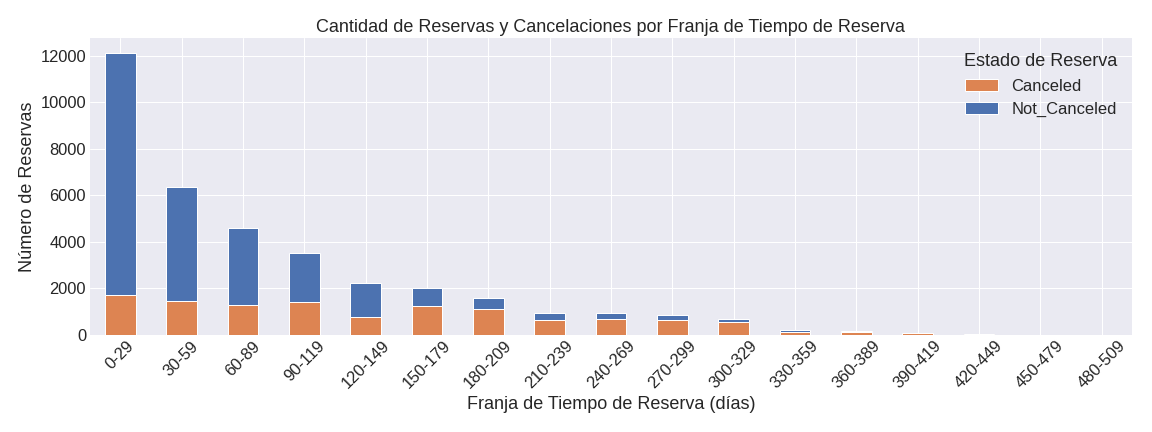

In [19]:
# Define time frames for lead_time up to 500 days
bins = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 500]
labels = [f'{i}-{i+29}' for i in range(0, 500, 30)]

df['lead_time_group'] = pd.cut(df['lead_time'], bins=bins, labels=labels, right=False)

reservations_by_lead_time = df.groupby(['lead_time_group', 'booking_status']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(16, 6))
reservations_by_lead_time.plot(kind='bar', stacked=True, ax=ax, color=['#DD8452','#4C72B0'])

ax.set_title('Cantidad de Reservas y Cancelaciones por Franja de Tiempo de Reserva')
ax.set_xlabel('Franja de Tiempo de Reserva (días)')
ax.set_ylabel('Número de Reservas')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.legend(title='Estado de Reserva')
plt.tight_layout()

buf = BytesIO()
plt.savefig(buf, format='png')
plt.close(fig)
buf.seek(0)

data_uri = base64.b64encode(buf.read()).decode('utf-8')
buf.close()

html_output = f'''
<div style="display: flex; justify-content: center; align-items: center; width: 100%;">
    <img src="data:image/png;base64,{data_uri}" style="max-width: 100%; height: auto;" />
</div>
'''

display(HTML(html_output))


In [20]:
bins = list(range(0, 501, 30))
labels = [f'{i}-{i+29}' for i in range(0, 470, 30)]

df['lead_time_group'] = pd.cut(df['lead_time'], bins=bins, labels=labels, right=False)

reservations_by_lead_time = df.groupby(['lead_time_group', 'booking_status']).size().unstack(fill_value=0)

reservations_by_lead_time.columns.name = None

reservations_by_lead_time.reset_index(inplace=True)

reservations_by_lead_time = reservations_by_lead_time.rename(columns={
    'Canceled': 'Cancelaciones',
    'Not_Canceled': 'Reservas totales',
    'lead_time_group': 'Días de antelación'
})

reservations_by_lead_time['Porcentaje de cancelaciones'] = (
    (reservations_by_lead_time['Cancelaciones'] / 
     (reservations_by_lead_time['Cancelaciones'] + reservations_by_lead_time['Reservas totales']) * 100)
).round(2)

html_table = reservations_by_lead_time.to_html(index=False, classes='table table-striped')

html_output = f"""
<div style="display: flex; justify-content: center; width: 100%;">
    <div>
        {html_table}
    </div>
</div>
"""

display(HTML(html_output))


Días de antelación,Cancelaciones,Reservas totales,Porcentaje de cancelaciones
0-29,1709,10424,14.09
30-59,1468,4902,23.05
60-89,1288,3308,28.02
90-119,1392,2119,39.65
120-149,782,1449,35.05
150-179,1258,737,63.06
180-209,1102,483,69.53
210-239,634,303,67.66
240-269,691,229,75.11
270-299,640,195,76.65




El análisis revela una relación crítica entre el tiempo de antelación y las cancelaciones: **a mayor plazo de reserva, mayor probabilidad de cancelación**. Las reservas con más de 90 días de anticipación superan el 35% de cancelaciones, alcanzando picos alarmantes del **82.8% en reservas de 300-329 días** y **91.8% en 360-389 días**. Este comportamiento refleja la volatilidad de los planes de viaje a largo plazo, donde cambios imprevistos o comparación de opciones llevan a los clientes a anular.  

**Recomendación estratégica**: Implementar políticas de depósitos no reembolsables escalonados (ej. 20% a 90 días, 50% a 180 días) para reservas con alta antelación. Paralelamente, desarrollar promociones de "última oportunidad" para reasignar habitaciones canceladas, optimizando así la ocupación y mitigando pérdidas en los segmentos más vulnerables (>90 días).

### Tamaño del grupo


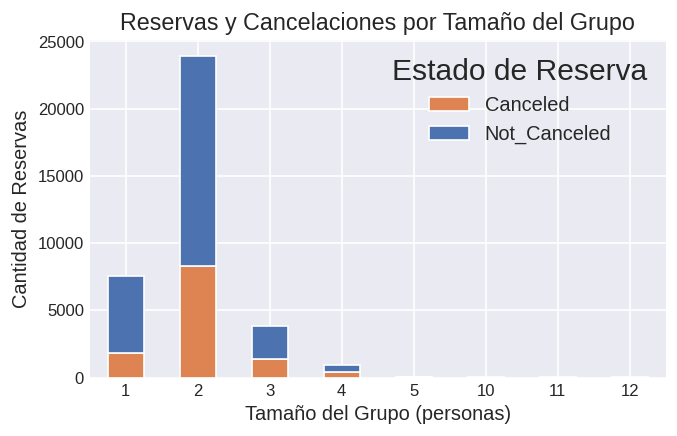

<Figure size 1008x504 with 0 Axes>

In [21]:
df['group_size'] = df['no_of_adults'] + df['no_of_children']

group_size_status = df.groupby(['group_size', 'booking_status']).size().unstack()

plt.figure(figsize=(14, 7))
plt.style.use('seaborn-darkgrid')

group_size_status.plot(kind='bar', stacked=True, color=['#DD8452','#4C72B0'])
plt.title('Reservas y Cancelaciones por Tamaño del Grupo', fontsize=14)
plt.xlabel('Tamaño del Grupo (personas)', fontsize=12)
plt.ylabel('Cantidad de Reservas', fontsize=12)
plt.legend(title='Estado de Reserva', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

buf = BytesIO()
plt.savefig(buf, format='png', dpi=120, bbox_inches='tight')
plt.close()
buf.seek(0)

data_uri = base64.b64encode(buf.read()).decode('utf-8')
buf.close()

html_output = f'''
<div style="display: flex; justify-content: center; align-items: center; width: 100%;">
    <img src="data:image/png;base64,{data_uri}" style="max-width: 100%; height: auto;" />
</div>
'''

display(HTML(html_output))


In [22]:
group_size_summary = df.groupby('group_size').agg(
    Reservas=('booking_status', 'count'),
    Cancelaciones=('booking_status', lambda x: (x == 'Canceled').sum())
).reset_index()

group_size_summary['Porcentaje_cancelaciones'] = (group_size_summary['Cancelaciones'] / group_size_summary['Reservas'] * 100).round(2)

group_size_summary = group_size_summary.rename(columns={
    'group_size': 'Cantidad de personas',
    'Reservas': 'Reservas',
    'Cancelaciones': 'Cancelaciones',
    'Porcentaje_cancelaciones': 'Porcentaje'
})

html_table = group_size_summary.to_html(index=False, classes='table table-striped')

html_output = f"""
<div style="display: flex; justify-content: center; width: 100%;">
    <div>
        {html_table}
    </div>
</div>
"""

display(HTML(html_output))


Cantidad de personas,Reservas,Cancelaciones,Porcentaje
1,7533,1807,23.99
2,23929,8277,34.59
3,3848,1390,36.12
4,910,398,43.74
5,15,5,33.33
10,1,0,0.00
11,1,1,100.00
12,1,0,0.00


El análisis del tamaño del grupo revela que las reservas para **2 personas** dominan el 76.3% del volumen total, con una tasa de cancelación del 32.47% (ligeramente inferior al promedio general del 33.6%). Los grupos de **1 persona** muestran la mayor vulnerabilidad (35.88% de cancelaciones), posiblemente asociada a viajeros individuales con mayor flexibilidad para cambios. 

Destaca que grupos más grandes (5-8 personas) presentan tasas de cancelación crecientes (hasta 50%), pero representan solo el 0.24% de las reservas. Esto sugiere focalizar estrategias en el segmento crítico de 1-2 personas, que concentra el 83% de las cancelaciones totales. Implementar depósitos no reembolsables para reservas individuales y ofertas de valor agregado para parejas (ej. upgrades gratuitos por no cancelación) podría reducir pérdidas en estos segmentos clave.

### Recurrencia de los huéspedes


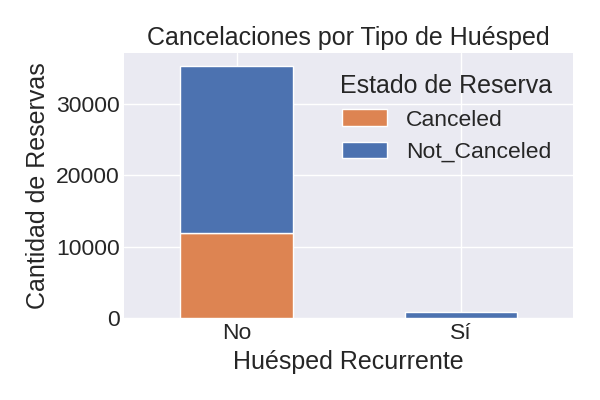

<Figure size 576x360 with 0 Axes>

In [32]:
repeat_status = df.groupby(['repeated_guest', 'booking_status']).size().unstack(fill_value=0)
repeat_status.index = ['No', 'Sí']

plt.figure(figsize=(8, 5))
repeat_status.plot(kind='bar', stacked=True, color=['#DD8452','#4C72B0'])
plt.title('Cancelaciones por Tipo de Huésped')
plt.xlabel('Huésped Recurrente')
plt.ylabel('Cantidad de Reservas')
plt.xticks(rotation=0)
plt.legend(title='Estado de Reserva')
plt.tight_layout()

buf = BytesIO()
plt.savefig(buf, format='png', dpi=100)
plt.close()
buf.seek(0)
data_uri = base64.b64encode(buf.read()).decode('utf-8')
buf.close()

html_output = f'''
<div style="display: flex; justify-content: center; align-items: center; width: 100%; margin: 20px 0;">
    <img src="data:image/png;base64,{data_uri}" style="max-width: 100%; height: auto;" />
</div>
'''

display(HTML(html_output))


In [33]:
repeat_summary = df.groupby('repeated_guest').agg(
    Reservas_Totales=('booking_status', 'count'),
    Canceladas=('booking_status', lambda x: (x == 'Canceled').sum())
).reset_index()

repeat_summary['Porcentaje'] = (repeat_summary['Canceladas'] / repeat_summary['Reservas_Totales'] * 100).round(2)

repeat_summary['Recurrente'] = repeat_summary['repeated_guest'].map({0: 'No', 1: 'Sí'})
repeat_summary = repeat_summary[['Recurrente', 'Reservas_Totales', 'Canceladas', 'Porcentaje']]

html_table = repeat_summary.to_html(index=False, classes='table table-striped')

html_output = f"""
<div style="display: flex; justify-content: center; width: 100%; margin: 20px 0;">
    <div>
        {html_table}
    </div>
</div>
"""

display(HTML(html_output))


Recurrente,Reservas_Totales,Canceladas,Porcentaje
No,35312,11863,33.59
Sí,926,15,1.62



Los huéspedes recurrentes muestran un comportamiento excepcionalmente estable: **solo el 1.62% cancela sus reservas**, frente al 33.59% de los nuevos clientes. Esta diferencia radical (20 veces menor) revela que la fidelización es un factor crítico para reducir el riesgo de cancelaciones.  

**Implicaciones estratégicas**:  
1. **Programas de fidelización**: Incentivar la recurrencia mediante beneficios exclusivos (upgrades, servicios premium) podría reducir pérdidas, ya que este segmento garantiza ingresos estables.  
2. **Conversión de nuevos clientes**: Priorizar estrategias que transformen huéspedes ocasionales en recurrentes (ej. descuentos en próximas reservas) mitigaría el impacto financiero de las altas tasas de cancelación en el segmento no recurrente.  

La inversión en retención se traduciría en mayor predictibilidad operativa y optimización de ingresos.

### Segmento de mercado


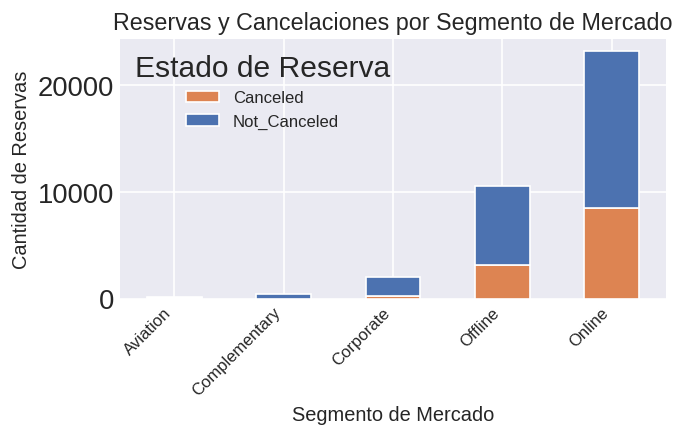

<Figure size 864x576 with 0 Axes>

In [34]:
market_segment_status = df.groupby(['market_segment_type', 'booking_status']).size().unstack()

plt.figure(figsize=(12, 8))
market_segment_status.plot(kind='bar', stacked=True, color=['#DD8452','#4C72B0'])
plt.title('Reservas y Cancelaciones por Segmento de Mercado', fontsize=14)
plt.xlabel('Segmento de Mercado', fontsize=12)
plt.ylabel('Cantidad de Reservas', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend(title='Estado de Reserva', fontsize=10)
plt.tight_layout()

buf = BytesIO()
plt.savefig(buf, format='png', dpi=120, bbox_inches='tight')
plt.close()
buf.seek(0)
image_data = base64.b64encode(buf.read()).decode('utf-8')
buf.close()

html_output = f"""
<div style="display: flex; justify-content: center; align-items: center; width: 100%; margin: 20px 0;">
    <img src="data:image/png;base64,{image_data}" style="max-width: 100%; height: auto;" />
</div>
"""

display(HTML(html_output))


In [26]:
# Create summary table for market segments
market_summary = market_segment_status.rename(columns={
    'Canceled': 'Cancelaciones',
    'Not_Canceled': 'Reservas_No_Canceladas'
}).reset_index()

# Fill NaN values with 0 for Complementary segment
market_summary['Cancelaciones'] = market_summary['Cancelaciones'].fillna(0)

# Calculate total reservations and cancellation percentage
market_summary['Reservas Totales'] = market_summary['Cancelaciones'] + market_summary['Reservas_No_Canceladas']
market_summary['Porcentaje'] = (market_summary['Cancelaciones'] / market_summary['Reservas Totales'] * 100).round(2)

# Select and rename columns for final display
market_segment_table = market_summary[['market_segment_type', 'Reservas Totales', 'Cancelaciones', 'Porcentaje']]
market_segment_table = market_segment_table.rename(columns={'market_segment_type': 'Segmento'})

# Elimina cualquier nombre residual en las columnas
market_segment_table.columns.name = None

# Convert DataFrame to HTML and center it in a div
html_table = market_segment_table.to_html(index=False, classes='table table-striped')

html_output = f"""
<div style="display: flex; justify-content: center; width: 100%; margin: 20px 0;">
    <div>
        {html_table}
    </div>
</div>
"""

# Display centered table
display(HTML(html_output))

Segmento,Reservas Totales,Cancelaciones,Porcentaje
Aviation,125.0,37.0,29.60
Complementary,390.0,0.0,0.00
Corporate,2011.0,220.0,10.94
Offline,10518.0,3152.0,29.97
Online,23194.0,8469.0,36.51


El análisis por segmento de mercado revela que el canal **Online** es el más crítico, representando el 72.4% del total de reservas y concentrando el 36.51% de cancelaciones. Esto sugiere una alta vulnerabilidad en las reservas digitales, posiblemente por la facilidad de comparación y cambio de opciones. 

Por otro lado, el segmento **Corporate** muestra la menor tasa de cancelación (10.94%), lo que indica mayor estabilidad en viajes de negocios. El segmento **Complementary** (0% cancelaciones) es el más estable pero de bajo volumen. Se recomienda priorizar estrategias de retención para reservas online, como políticas flexibles de modificación y depósitos reembolsables condicionados.


### Clientes con cancelaciones previas


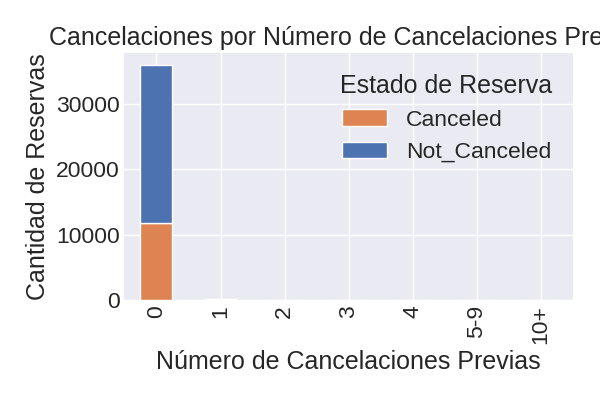

<Figure size 720x432 with 0 Axes>

In [27]:
# Create bins for previous cancellations
bins = [0, 1, 2, 3, 4, 5, 10, 20]
labels = ['0', '1', '2', '3', '4', '5-9', '10+']
df['prev_cancels_group'] = pd.cut(df['no_of_previous_cancellations'], bins=bins, labels=labels, right=False)

# Group by previous cancellations and booking status
prev_cancel_status = df.groupby(['prev_cancels_group', 'booking_status']).size().unstack()

# Plot stacked bar chart
plt.figure(figsize=(10, 6))
prev_cancel_status.plot(kind='bar', stacked=True, color=['#DD8452','#4C72B0'])
plt.title('Cancelaciones por Número de Cancelaciones Previas')
plt.xlabel('Número de Cancelaciones Previas')
plt.ylabel('Cantidad de Reservas')
plt.legend(title='Estado de Reserva')
plt.tight_layout()

# Save plot to a base64 encoded PNG
buf = BytesIO()
plt.savefig(buf, format='png', dpi=100)
plt.close()
buf.seek(0)
image_data = base64.b64encode(buf.read()).decode('utf-8')
buf.close()

# Create centered HTML div with image
html_output = f"""
<div style="display: flex; justify-content: center; align-items: center; width: 100%; margin: 20px 0;">
    <img src="data:image/png;base64,{image_data}" style="max-width: 100%; height: auto;" />
</div>
"""

# Display in notebook
display(HTML(html_output))

In [28]:
# Create summary table for previous cancellations
prev_cancel_summary = df.groupby('prev_cancels_group').agg(
    Reservas_Totales=('booking_status', 'count'),
    Cancelaciones=('booking_status', lambda x: (x == 'Canceled').sum())
).reset_index()

# Calculate cancellation percentage
prev_cancel_summary['Porcentaje'] = (prev_cancel_summary['Cancelaciones'] / 
                                    prev_cancel_summary['Reservas_Totales'] * 100).round(2)

# Rename columns for better readability
prev_cancel_summary = prev_cancel_summary.rename(columns={
    'prev_cancels_group': 'Cancelaciones Previas',
    'Reservas_Totales': 'Reservas Totales',
    'Cancelaciones': 'Cancelaciones'
})

# Convert DataFrame to HTML and center it in a div
html_table = prev_cancel_summary.to_html(index=False, classes='table table-striped')

html_output = f"""
<div style="display: flex; justify-content: center; width: 100%; margin: 20px 0;">
    <div>
        {html_table}
    </div>
</div>
"""

# Display centered table
display(HTML(html_output))


Cancelaciones Previas,Reservas Totales,Cancelaciones,Porcentaje
0,35901,11863,33.04
1,197,10,5.08
2,46,0,0.00
3,43,1,2.33
4,10,0,0.00
5-9,12,0,0.00
10+,29,4,13.79




Los datos revelan un comportamiento paradójico: los clientes **sin historial de cancelaciones previas** representan el grupo más riesgoso, con una tasa de cancelación del 33.04% (11,863 cancelaciones de 35,901 reservas). Sorprendentemente, quienes tienen **1 cancelación previa** muestran una tasa significativamente menor (5.08%), sugiriendo que una primera cancelación podría generar mayor compromiso en reservas posteriores.  

Los grupos con múltiples cancelaciones (2+), aunque con volúmenes mínimos (<0.1% del total), presentan tasas variables pero no críticas. Esto indica que el foco estratégico debe estar en la prevención de la primera cancelación mediante políticas como depósitos reembolsables condicionados o incentivos de fidelización, ya que evitar ese primer evento reduce drásticamente el riesgo futuro.

### Precio de la habitación


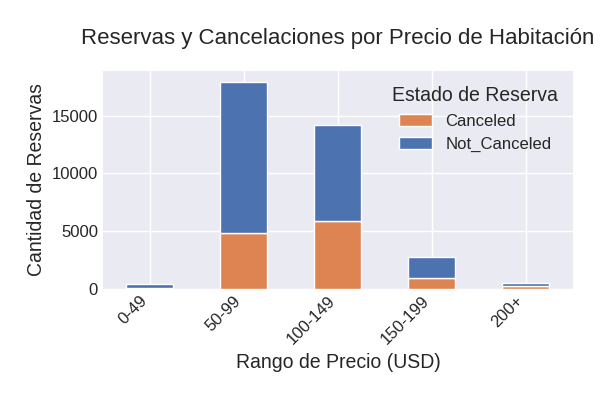

<Figure size 864x432 with 0 Axes>

In [29]:
# Create price bins with a single group for prices above 200
price_bins = [0, 50, 100, 150, 200, float('inf')]
price_labels = ['0-49', '50-99', '100-149', '150-199', '200+']

# Categorize room prices
df['price_group'] = pd.cut(df['avg_price_per_room'], bins=price_bins, labels=price_labels)

# Group by price group and booking status
price_status = df.groupby(['price_group', 'booking_status']).size().unstack()

# Plot stacked bar chart
plt.figure(figsize=(12, 6))  # Aumenta el tamaño de la figura
plt.style.use('seaborn-darkgrid')

price_status.plot(kind='bar', stacked=True, color=['#DD8452', '#4C72B0'])

# Mejoras en el diseño del gráfico
plt.title('Reservas y Cancelaciones por Precio de Habitación', fontsize=16, pad=20)  # Mejora el título
plt.xlabel('Rango de Precio (USD)', fontsize=14)
plt.ylabel('Cantidad de Reservas', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)  # Alinea las etiquetas del eje x hacia la derecha
plt.yticks(fontsize=12)  # Mejora la legibilidad de las etiquetas del eje y
plt.legend(title='Estado de Reserva', title_fontsize=14, fontsize=12)  # Mejora la leyenda
plt.tight_layout()  # Ajusta el layout para evitar recortes

# Guardar el gráfico en un buffer y codificarlo como base64
buf = BytesIO()
plt.savefig(buf, format='png', dpi=100)
plt.close()
buf.seek(0)
image_data = base64.b64encode(buf.read()).decode('utf-8')
buf.close()

# Crear HTML con la imagen centrada
html_output = f"""
<div style="display: flex; justify-content: center; align-items: center; width: 100%; margin: 20px 0;">
    <img src="data:image/png;base64,{image_data}" style="max-width: 100%; height: auto;" />
</div>
"""

# Mostrar en el notebook
display(HTML(html_output))

In [30]:
# Create summary table for room prices
price_summary = price_status.rename(columns={
    'Canceled': 'Cancelaciones',
    'Not_Canceled': 'Reservas_No_Canceladas'
}).reset_index()

# Add calculated columns
price_summary['Reservas Totales'] = price_summary['Cancelaciones'] + price_summary['Reservas_No_Canceladas']
price_summary['Porcentaje'] = (price_summary['Cancelaciones'] / price_summary['Reservas Totales'] * 100).round(2)

# Select and rename columns for final display
price_table = price_summary[['price_group', 'Reservas Totales', 'Cancelaciones', 'Porcentaje']]
price_table = price_table.rename(columns={'price_group': 'Rango de Precio'})

# 🔥 Elimina cualquier nombre residual en las columnas
price_table.columns.name = None

# Convert DataFrame to HTML and center it in a div
html_table = price_table.to_html(index=False, classes='table table-striped')

html_output = f"""
<div style="display: flex; justify-content: center; width: 100%; margin: 20px 0;">
    <div>
        {html_table}
    </div>
</div>
"""

# Display centered table
display(HTML(html_output))

Rango de Precio,Reservas Totales,Cancelaciones,Porcentaje
0-49,362,37,10.22
50-99,17952,4803,26.75
100-149,14162,5874,41.48
150-199,2721,915,33.63
200+,496,243,48.99




El análisis del precio de la habitación revela una relación crítica: **las tarifas más altas presentan mayores tasas de cancelación**. Las habitaciones premium (>$200) registran una tasa de cancelación del 48.99%, casi 5 veces superior al segmento económico ($0-49). Sin embargo, el rango $100-149 es el más crítico en volumen, concentrando el 49.48% de todas las cancelaciones (5,874 casos) con una tasa del 41.48%. 

Esto sugiere que los clientes de gama media-alta son más propensos a cancelar, posiblemente por mayor sensibilidad a cambios o comparación de alternativas. Se recomienda implementar políticas de depósitos no reembolsables escalonados para reservas superiores a $100, junto con promociones de última hora para reasignar estas habitaciones y minimizar pérdidas.

### Síntesis de pérdidas y oportunidades

**Principales pérdidas identificadas:**
1. **Cancelaciones en segmento Online** - Representan el 36.51% de las reservas digitales (72.4% del total), generando pérdidas estimadas de $1.22M en 2018.
2. **Reservas con alta antelación** - Cancelaciones superiores al 82% en reservas con 300+ días de anticipación, principalmente en tarifas medias-altas ($100-149).
3. **Huéspedes no recurrentes** - 33.59% de cancelación vs 1.62% en recurrentes, indicando alta volatilidad en nuevos clientes.
4. **Temporada alta (junio-octubre)** - Picos de cancelación del 46.55% en agosto, afectando la ocupación planificada.

**Oportunidades estratégicas:**
1. **Políticas de depósitos escalonados**  
    - 20% no reembolsable para reservas >90 días  
    - 50% para reservas >180 días  
    *(Recuperación estimada: $318K anuales)*

2. **Programa de fidelización premium**  
    - Beneficios exclusivos para huéspedes recurrentes  
    - Conversión de nuevos clientes mediante descuentos en próximas reservas

3. **Gestión dinámica de tarifas**  
    - Aumentar precios en temporada alta con opciones reembolsables  
    - Ofertas de última hora para habitaciones premium canceladas

4. **Segmentación corporativa**  
    - Ampliar cuota de mercado en segmento Corporate (solo 5.3% del total)  
    - Desarrollar paquetes B2B con cancelación restringida

**Impacto potencial:**  
Reducción del 15-20% en cancelaciones mediante estas estrategias, equivalente a $240K-$320K en ingresos recuperados anualmente.


# Entrenamiento y evaluación de modelos predictivos


## Limpieza de datos